In [25]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.neighbors import KernelDensity

In [26]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [27]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [28]:
def readData():
    path = 'resources/'
    fileName = 'cpd-crash-incidents.csv'
    data = pd.read_csv(path + fileName, sep=';')
    data.dropna(subset=['lon', 'lat', 'crash_date'], inplace=True)
    return data
data = readData()
# print(data['lon'][:10])
# print(data['lat'][:10])
# print(data['crash_date'][:10])

In [29]:
def makeTimeColumn(data):
    crash_date = pd.to_datetime(data['crash_date'])
    hours = crash_date.dt.hour
    minutes = crash_date.dt.minute
    seconds = crash_date.dt.second
    time = hours + minutes/60 + seconds/3600 
    data['time'] = time

makeTimeColumn(data)
time = data['time']

In [30]:
def getShiftedTime_9(crash_date):
    crash_date = pd.to_datetime(data['crash_date'])
    hours = crash_date.dt.hour
    minutes = crash_date.dt.minute
    seconds = crash_date.dt.second
    time = hours + minutes/60 + seconds/3600 
    shifted_time = time.apply(lambda x: x + 24 if x < 9 else x)
    shifted_time = shifted_time.apply(lambda x: x - 9)
    
    return shifted_time

time_shift_9 = getShiftedTime_9(data)

# prob2a

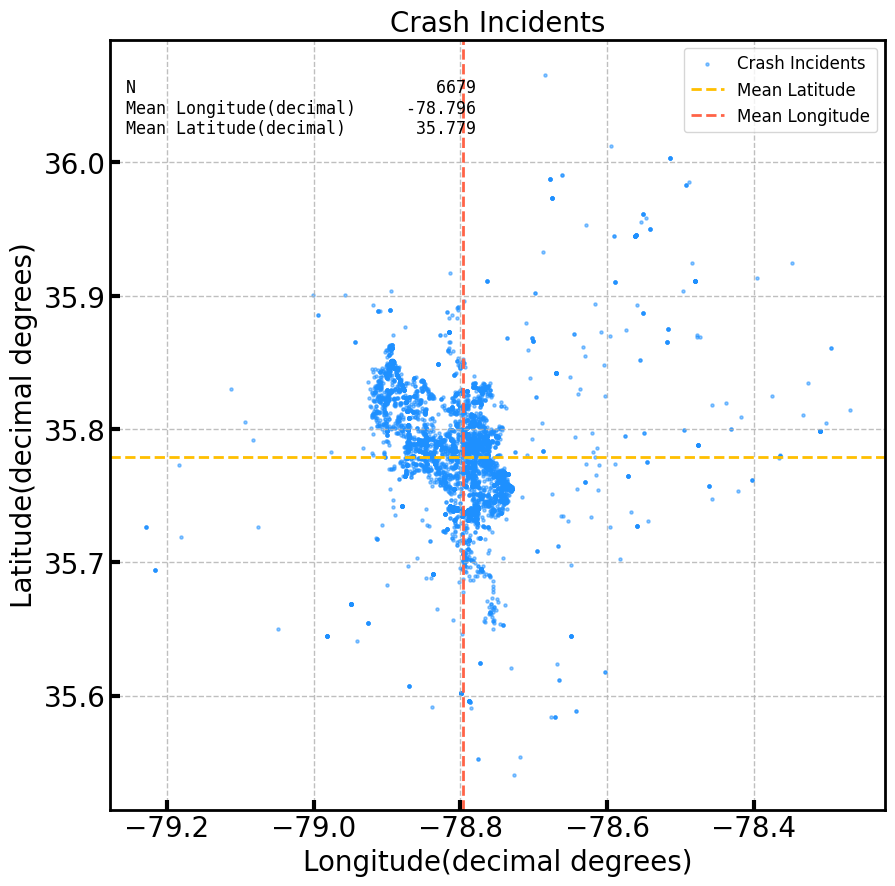

In [31]:
def scatterLatLong(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(data['lon'], data['lat'], s=5, alpha=0.5, label='Crash Incidents')
    ax.axhline(np.mean(data['lat']), c = COLOUR[1], linestyle='--', label='Mean Latitude')
    ax.axvline(np.mean(data['lon']), c = COLOUR[2], linestyle='--', label='Mean Longitude')
    ax.set_xlabel('Longitude(decimal degrees)')
    ax.set_ylabel('Latitude(decimal degrees)')
    ax.set_title('Crash Incidents')
    d = {'N' : len(data), 
         'Mean Longitude(decimal)' : np.mean(data['lon']), 
         'Mean Latitude(decimal)' : np.mean(data['lat'])}
    add_text_to_ax(0.02, 0.95, nice_string_output(d), ax, fontsize=12)
    ax.legend()
scatterLatLong(data)

In [32]:
def getHistoParamWithBinWidth(data, binwidth, isDensity = False):
    start_bin = np.floor(data.min()) - 0.5 * binwidth
    end_bin = np.ceil(data.max()) + 0.5 * binwidth
    bins = np.arange(start_bin, end_bin + binwidth, binwidth)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    counts, x_edges = np.histogram(data, bins=bins, density=isDensity)
    x_centres = x_edges[:-1] + binwidth/2
    return bins, counts, bin_centers, x_centres

In [33]:
def buildHistoTexts(title, label, binwidth, 
                    d_text_x, 
                    d_text_y, 
                    xlabel = 'X', 
                    ylabel = 'Y', 
                    rotation = 0, 
                    density = False,
                    additional_d = {}):
    texts = {}
    texts['title'] = title
    texts['label'] = label
    texts['binwidth'] = binwidth
    texts['d_x'] = d_text_x
    texts['d_y'] = d_text_y
    texts['xlabel'] = xlabel
    texts['ylabel'] = ylabel
    texts['rotation'] = rotation
    texts['density'] = density
    texts['add_d'] = additional_d
    return texts

In [34]:
def plotHistoCore(data, texts):
    title = texts['title']
    label = texts['label']
    binwidth = texts['binwidth']
    xlabel = texts['xlabel']
    ylabel = texts['ylabel']
    d_text_x = texts['d_x']
    d_text_y = texts['d_y']
    rotation = texts['rotation']
    density = texts['density']
        
    fig, ax = plt.subplots(figsize=(12, 9))
    bins, counts, bin_centers, x_centres = getHistoParamWithBinWidth(data, binwidth)
    Nbins = len(bins)
    _, _, patches = ax.hist(data, bins=bins, rwidth=0.9, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xticks(bin_centers)
    ax.set_xticklabels([f'{int(label)}' for label in bin_centers], rotation=rotation)
    ax.legend()

    # display the count of each bar on the top
    for patch, count in zip(patches, counts):
         height = patch.get_height()
         ax.text(patch.get_x() + patch.get_width() / 2.,
                  height, f'{count:.0f}', 
                  ha='center', va='bottom', 
                  fontsize=12)
    add_d = texts['add_d']
    d = {'N': len(data), 
         'Nbins': Nbins, 
         'binwidth': f'{binwidth:.2f}',
         'Mean': f'{np.mean(data):.1f}',
         'Median': f'{np.median(data):.1f}',
         'Std': f'{np.std(data):.1f}',
         
         }
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(d_text_x, d_text_y, text, ax, fontsize=12, color='k')

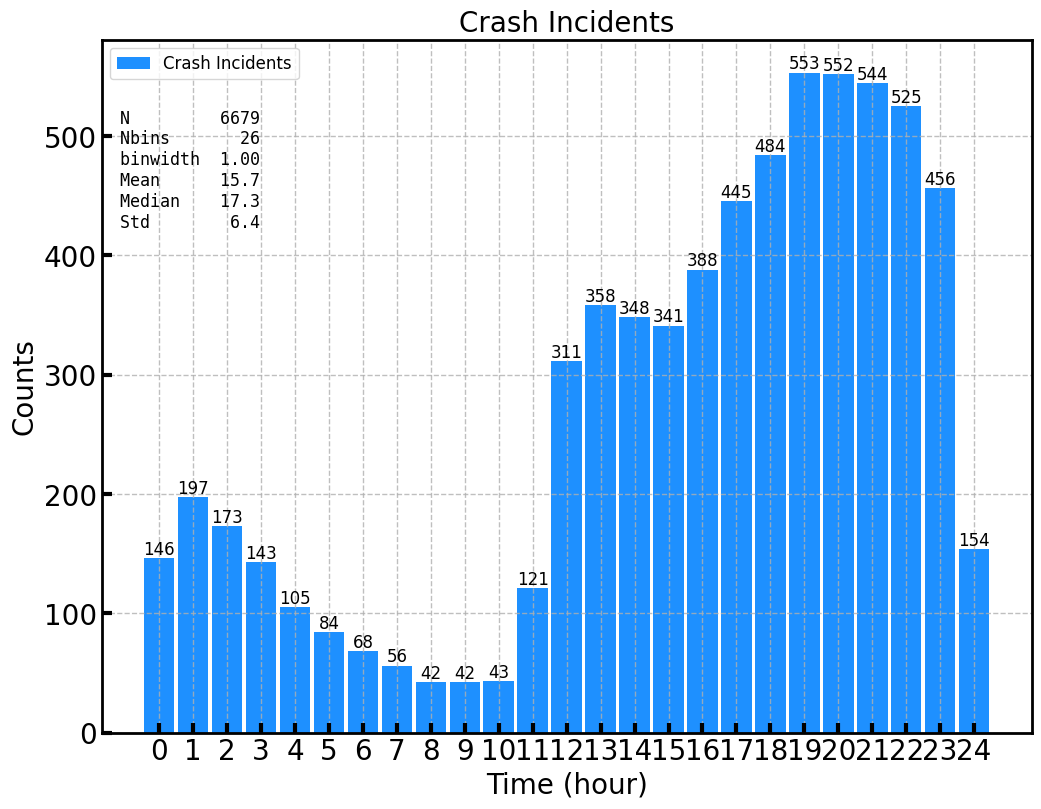

In [35]:
def plotHistogram():
    histoText_alive = buildHistoTexts('Crash Incidents',
                                    'Crash Incidents',
                                    1.0,
                                    0.02,
                                    0.90,
                                    'Time (hour)',
                                    'Counts')
    plotHistoCore(time, histoText_alive)
plotHistogram()

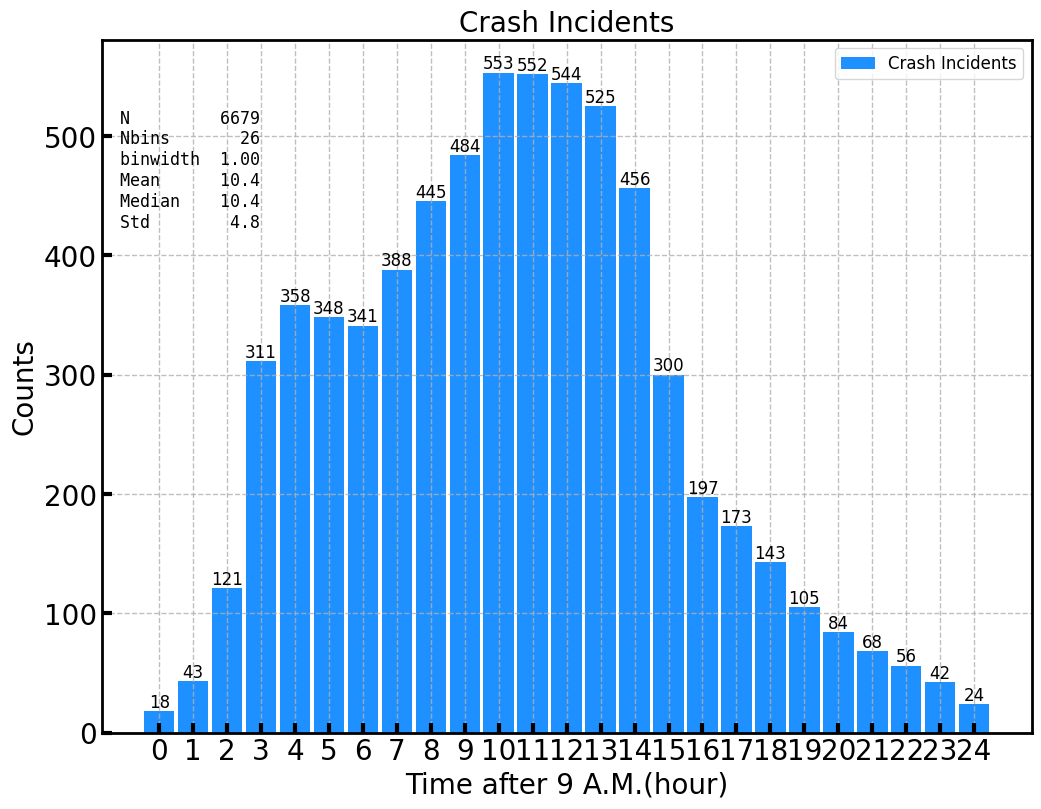

In [36]:
def plotHistogram_shifted():
    histoText_alive = buildHistoTexts('Crash Incidents',
                                    'Crash Incidents',
                                    1.0,
                                    0.02,
                                    0.90,
                                    'Time after 9 A.M.(hour)',
                                    'Counts')
    plotHistoCore(time_shift_9, histoText_alive)
plotHistogram_shifted()

## prob2a Gaussian KDE

* the data is in time of clock which can be a continuous variable if I can think about the previous or the following day.
* So I may shift the histogram to locate its summit to be around centre of my horizontal dimension, and then I will have a giant Gaussian-like peak with some hints of several minor Gaussian-like peaks may also contribute to the profile
* I shall choose to cut the data before 9 A.M. and put after 24:00. 
* Applying normal Gaussian formula for each time data point, it will give Gaussian KDE PDF
* 

# prob2b

## Prob2b Epanechnikov

In [37]:
def Epanechnikov(x, x0):
    width = 0.8
    u = (x - x0) / width
    return np.where(np.abs(u) <= 1, 3/4 * (1 - u**2), 0)

In [44]:
def KDEcore(data):
    DAY_STEP = 0.01
    DAY_START = 0
    DAY_END = 24
    DAY = np.arange(DAY_START, DAY_END, DAY_STEP)
    Epanechnikovs = []
    for t in tqdm(DAY):
        Epanechnikovs.append(Epanechnikov(data, t).sum())
    dt = DAY[1] - DAY[0]
    area = np.trapz(Epanechnikovs, dx=dt)
    kde = Epanechnikovs / area
    normalisation = np.trapz(kde, dx=dt)

    return DAY, kde, normalisation

In [53]:
def getInterestedTime(isShifted = False):
    str = '00:23, 01:49, 08:12, 15:55, 18:02, 21:12, 23:44'
    arr_str = str.split(', ')
    arr_num = [int(x.split(':')[0]) + int(x.split(':')[1])/60 for x in arr_str]
    if isShifted:
        arr_num = [x + 24 if x < 9 else x for x in arr_num]
        arr_num = [x - 9 for x in arr_num]
    return arr_num, arr_str

In [54]:
def getEvaluation(DAY, kde, isShifted = False):
    times, _ = getInterestedTime(isShifted)
    evaluation = np.zeros(len(times))
    dt = DAY[1] - DAY[0]
    for i, t in enumerate(times):
        evaluation[i] = kde[int(t/dt)]
    return evaluation

100%|██████████| 2400/2400 [00:02<00:00, 954.25it/s] 


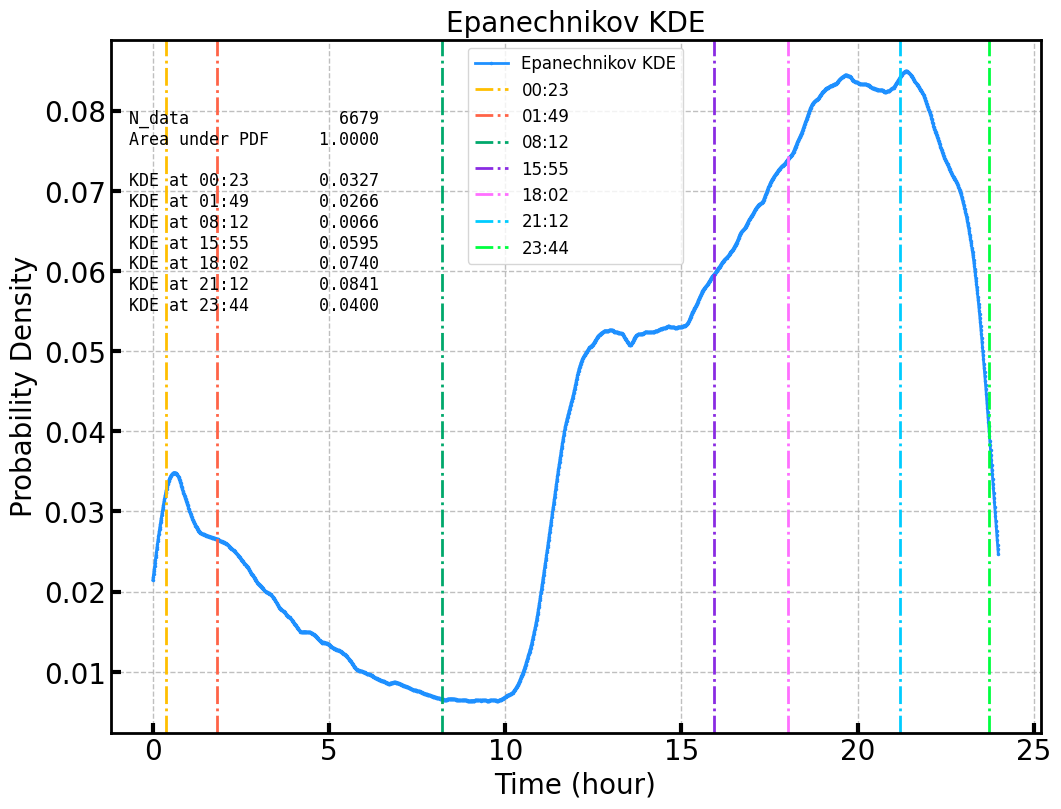

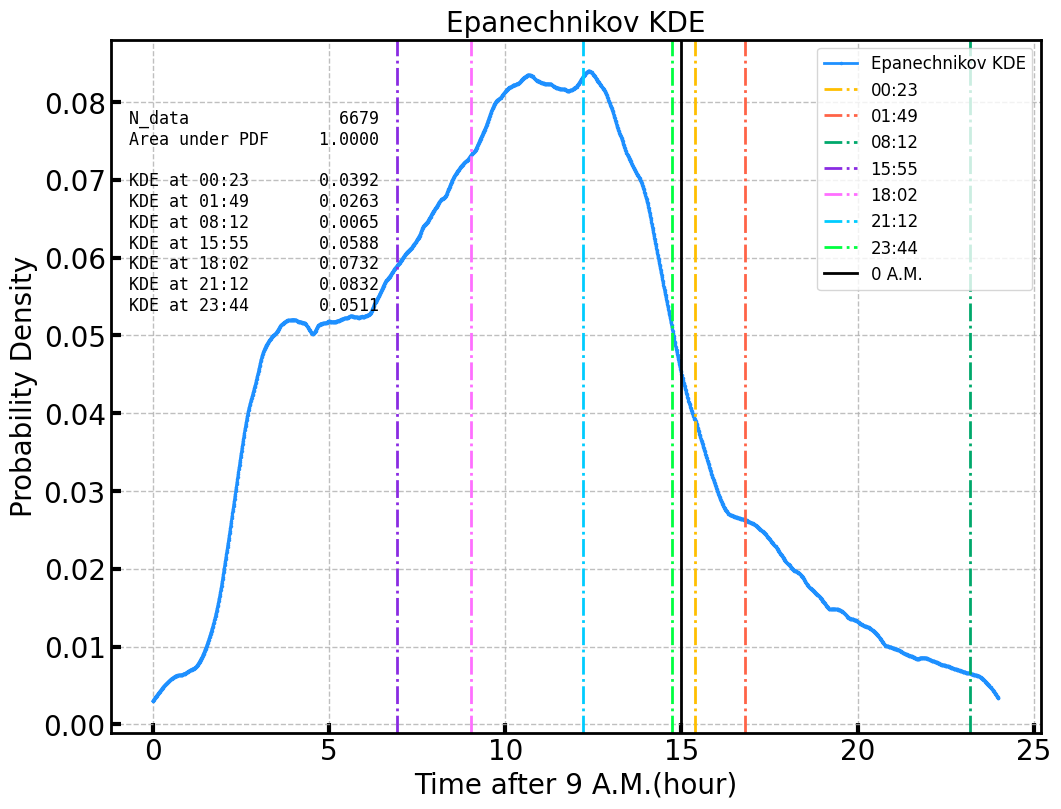

In [55]:
def plotEpanechnikovKDE(data, isShifted = False):
    DAY, kde, normalisation = KDEcore(data)
    evaluation = getEvaluation(DAY, kde, isShifted)
    t_intersted_num, t_intersted_str  = getInterestedTime(isShifted)
    
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.plot(DAY, kde, label='Epanechnikov KDE')
    for i, t in enumerate(t_intersted_num):
        ax.axvline(x=t, color=COLOUR[i+1], linestyle='-.', label=t_intersted_str[i])
    
    if isShifted:
        ax.axvline(x=15, color='k', linestyle='-', label='0 A.M.')
        ax.set_xlabel('Time after 9 A.M.(hour)')
        ax.legend(loc = 'upper right')
    else:
        ax.set_xlabel('Time (hour)')
        ax.legend(loc = 'upper center')
    ax.set_ylabel('Probability Density')
    ax.set_title('Epanechnikov KDE')
    d = {'N_data' : len(data), 
         'Area under PDF' : f'{normalisation:.4f}',
         '': '',
         }
    for i, t in enumerate(t_intersted_num):
        d[f'KDE at {t_intersted_str[i]}'] = f'{evaluation[i]:.4f}'
    add_text_to_ax(0.02, 0.90, nice_string_output(d), ax, fontsize=12)
plotEpanechnikovKDE(time)
plotEpanechnikovKDE(time_shift_9, True)

## Prob2b : window

In [49]:
def getWindows(DAY, min, max, dt):
    WINDOW_SIZE = 2
    starts = np.arange(min, max, dt)
    windows = []
    for i, start in enumerate(starts):
        end = start + WINDOW_SIZE
        window = (DAY >= start) & (DAY <= end)
        windows.append(window)
    return windows

  0%|          | 0/2400 [00:00<?, ?it/s]

100%|██████████| 2400/2400 [00:01<00:00, 1548.01it/s]


optimal choice: 19:33


100%|██████████| 2400/2400 [00:03<00:00, 739.64it/s] 


optimal choice: 19:33


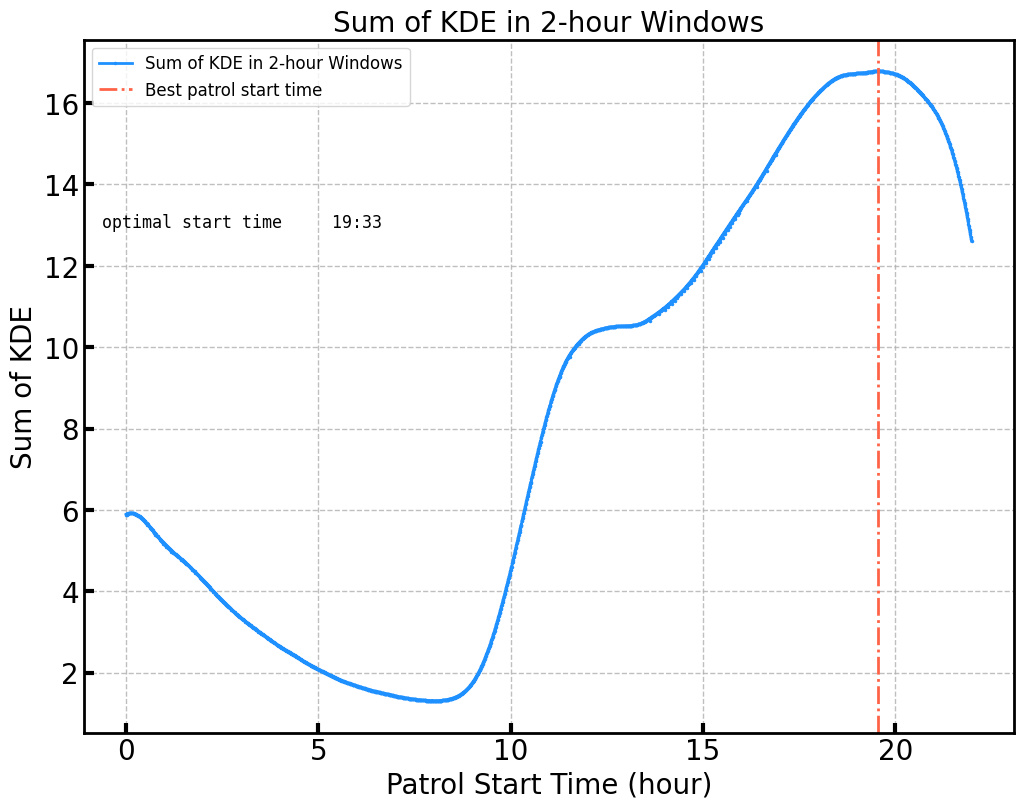

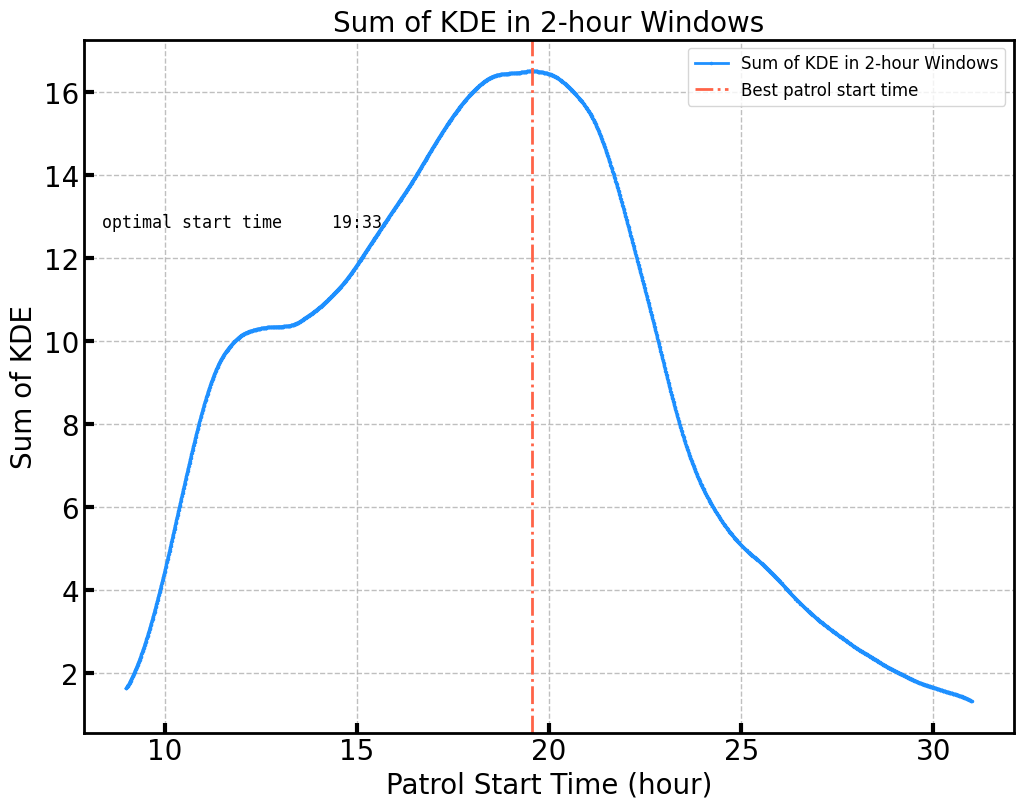

In [50]:
def best2hrWindow(data, isShifted = False):
    DAY, kde, _ = KDEcore(data)
    if isShifted:
        DAY = DAY + 9
    
    WINDOW_SIZE = 2
    w_min = DAY[0]
    w_max = DAY[-1] - WINDOW_SIZE
    dt = DAY[1] - DAY[0]
    
    window_starts = np.arange(w_min, w_max, dt)
    windows = getWindows(DAY, w_min, w_max, dt)
    window_sums = [kde[window].sum() for window in windows]

    best_start_time = window_starts[np.argmax(window_sums)]
    h = int(best_start_time)
    m = int((best_start_time - h) * 60)
    print(f'optimal choice: {h:02d}:{m:02d}')

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.plot(window_starts, window_sums, label='Sum of KDE in 2-hour Windows')
    ax.axvline(x=best_start_time, color=COLOUR[2], linestyle='-.', label='Best patrol start time')
    ax.set_xlabel('Patrol Start Time (hour)')
    ax.set_ylabel('Sum of KDE')
    ax.set_title('Sum of KDE in 2-hour Windows')
    ax.legend()
    d = {'optimal start time' : f'{h:02d}:{m:02d}',}
    add_text_to_ax(0.02, 0.75, nice_string_output(d), ax, fontsize=12)

best2hrWindow(time)
best2hrWindow(time_shift_9, True)

# prob2c

In [ ]:
def normalisation(PDF_values, longitudes, latitudes):
    dx = np.diff(longitudes).mean()
    dy = np.diff(latitudes).mean()
    unit_area = dx * dy
    return PDF_values.sum() * unit_area

In [ ]:
def getProportion(PDF_values, longitudes, latitudes, box_longitude, box_latitude):
    lon_min, lon_max = box_longitude
    lat_min, lat_max = box_latitude
    
    lon_indices = np.where((longitudes >= lon_min) & (longitudes <= lon_max))[0]
    lat_indices = np.where((latitudes >= lat_min) & (latitudes <= lat_max))[0]

    box = PDF_values[min(lat_indices):max(lat_indices)+1, min(lon_indices):max(lon_indices)+1]

    volume_box = box.sum()
    volume_total = PDF_values.sum()

    return volume_box / volume_total

Proportion of the region within the total area: 0.1339


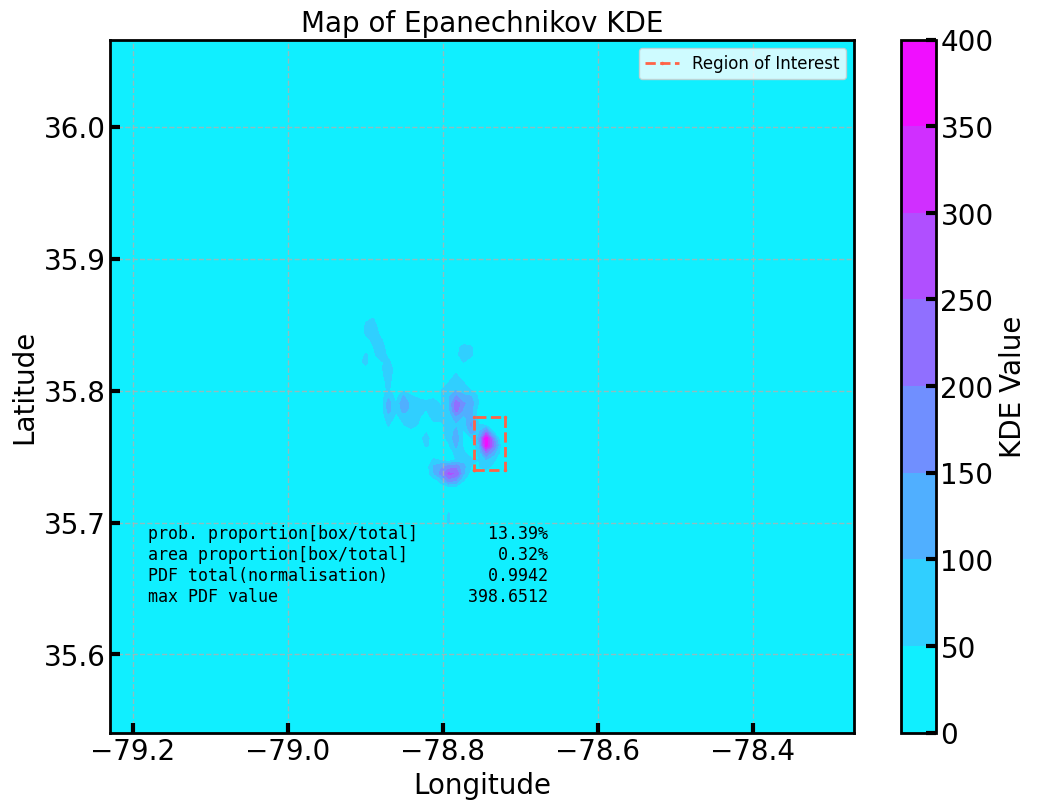

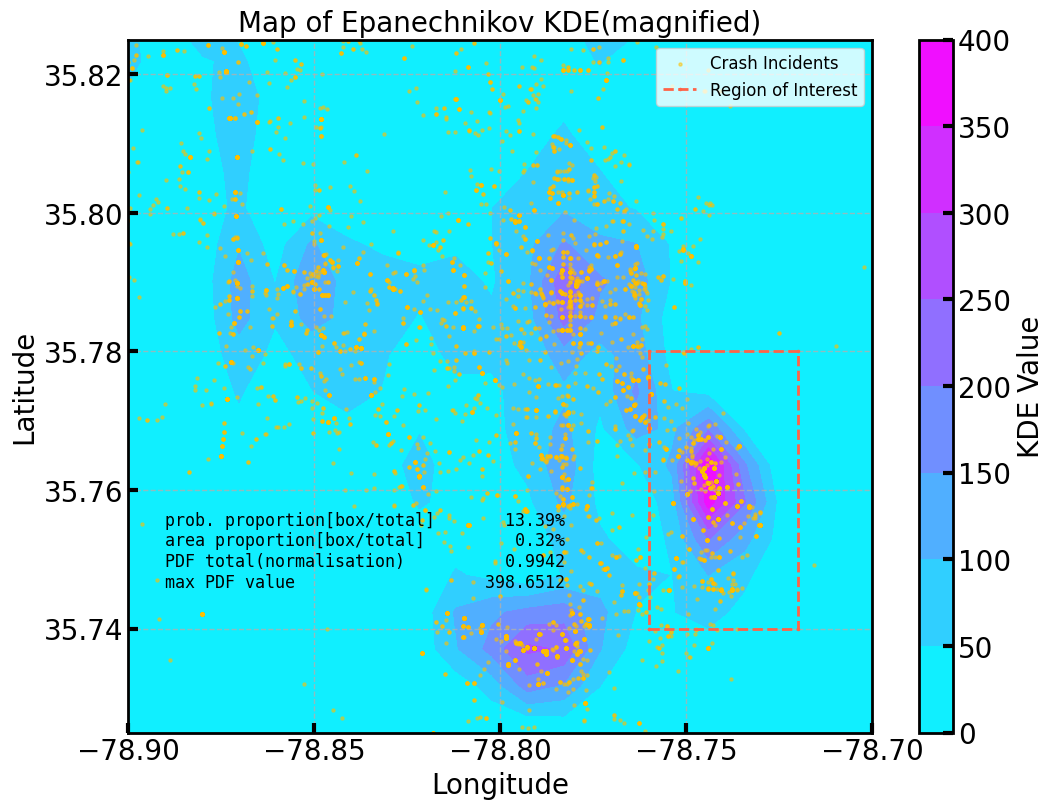

In [ ]:
def twoDimensionalEpanechnikovKDE(data):
    X = data[['lon', 'lat']].values
    kde = KernelDensity(bandwidth=0.01, kernel='epanechnikov')
    kde.fit(X)
    longitudes = np.linspace(data['lon'].min(), data['lon'].max(), 100)
    latitudes = np.linspace(data['lat'].min(), data['lat'].max(), 100)
    total_area = (longitudes.max() - longitudes.min()) * (latitudes.max() - latitudes.min())

    X_grid, Y_grid = np.meshgrid(longitudes, latitudes)
    grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

    # Calculate the log density (log PDF) values for the grid
    log_pdf_values = kde.score_samples(grid_points)
    PDF_values = np.exp(log_pdf_values).reshape(X_grid.shape)

    fig, ax = plt.subplots(figsize=(12, 9))
    contourf_plot = ax.contourf(X_grid, Y_grid, PDF_values, cmap = 'cool')
#     ax.scatter(data['lon'], data['lat'], s=5, color = COLOUR[2], alpha=0.5, label='Crash Incidents')
    fig.colorbar(contourf_plot, ax=ax, label='KDE Value')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Map of Epanechnikov KDE')

    ## box volume proportion
    box_longitude = np.array([-78.76, -78.72])
    box_latitude = np.array([35.74, 35.78])
    box_area = (box_longitude[1] - box_longitude[0]) * (box_latitude[1] - box_latitude[0])
    
    # plot
    ax.plot([box_longitude[0], box_longitude[1], box_longitude[1], box_longitude[0], box_longitude[0]], 
            [box_latitude[0], box_latitude[0], box_latitude[1], box_latitude[1], box_latitude[0]], 
            color=COLOUR[2], linestyle='--', label='Region of Interest')
    proportion = getProportion(PDF_values, longitudes, latitudes, box_longitude, box_latitude)
    print(f"Proportion of the region within the total area: {proportion:.4f}")
    ax.legend()

    # Add text to the plot
    d = {'prob. proportion[box/total]': f'{proportion:.2%}', 
         'area proportion[box/total]': f'{box_area / total_area:.2%}',
         'PDF total(normalisation)' : f'{normalisation(PDF_values, longitudes, latitudes):.4f}',
         'max PDF value' : f'{PDF_values.max():.4f}',
         }
    add_text_to_ax(0.05, 0.30, nice_string_output(d), ax, fontsize=12)


    fig_mag, ax_mag = plt.subplots(figsize=(12, 9))
    contourf_plot_mag = ax_mag.contourf(X_grid, Y_grid, PDF_values, cmap = 'cool')
    fig_mag.colorbar(contourf_plot_mag, ax=ax_mag, label='KDE Value')
    ax_mag.scatter(data['lon'], data['lat'], s=5, color = COLOUR[1], alpha=0.5, label='Crash Incidents')
    ax_mag.set_xlabel('Longitude')
    ax_mag.set_ylabel('Latitude')
    ax_mag.set_title('Map of Epanechnikov KDE(magnified)')
    ax_mag.set_xlim(-78.9, -78.7)
    ax_mag.set_ylim(35.725, 35.825)
    ax_mag.plot([box_longitude[0], box_longitude[1], box_longitude[1], box_longitude[0], box_longitude[0]], 
            [box_latitude[0], box_latitude[0], box_latitude[1], box_latitude[1], box_latitude[0]], 
            color=COLOUR[2], linestyle='--', label='Region of Interest')
    ax_mag.legend(loc = 'upper right')
    add_text_to_ax(0.05, 0.32, nice_string_output(d), ax_mag, fontsize=12)
    
twoDimensionalEpanechnikovKDE(data)